In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os

In [3]:
iskaggle=os.environ.get('KAGGE_KERNEL_RUN_TYPE','')

In [4]:
!pip install kaggle #downloading kaggle datasets to use in kaggle api

In [5]:
creds='{"username":"kkeshav1101","key":"a48fb8148c032d30e60f8a039e6f01b9"}'

In [6]:
from pathlib import Path
cred_path=Path('~/.kaggle/kaggle.json').expanduser()

if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [7]:
path = Path('us-patent-phrase-to-phrase-matching')

In [16]:
if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)
    #downloading files

In [11]:
if iskaggle:
    path = Path('../input/us-patent-phrase-to-phrase-matching')
    ! pip install -q datasets
    

In [12]:
!ls {path}

sample_submission.csv  test.csv  train.csv


In [13]:
import pandas as pd

In [14]:
df=pd.read_csv(path/'train.csv') #converting csv file to a dataframe

In [15]:
df
#peeking

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [17]:
df.describe(include='object')  #table desc

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [20]:
df['input']='TEXT1: '+df.context+'; TEXT2: '+df.target+'; ANC1: '+df.anchor

In [21]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

TOKENISATION

In [22]:
#transformers use a dataset object for storing a dataset lol.

In [23]:
#thus
from datasets import Dataset,DatasetDict
ds=Dataset.from_pandas(df)

In [24]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

But we can't pass the texts directly into a model, we have to numericalize the data tokens. Numericalization is the process of converting each word or token into a number.

In [25]:
model_nm='microsoft/deberta-v3-small'

In [27]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz=AutoTokenizer.from_pretrained(model_nm)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [28]:
tokz.tokenize("Chelsea is the best football club in the world")

['▁Chelsea',
 '▁is',
 '▁the',
 '▁best',
 '▁football',
 '▁club',
 '▁in',
 '▁the',
 '▁world']

In [29]:
tokz.tokenize('School being blah blah is an onomotopia')

['▁School', '▁being', '▁blah', '▁blah', '▁is', '▁an', '▁on', 'omo', 'topia']

In [30]:
def tok_func(x): return tokz(x["input"])

In [31]:
tok_ds=ds.map(tok_func,batched=True)

  0%|          | 0/37 [00:00<?, ?ba/s]

In [32]:
row=tok_ds[0]
row['input'],row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

In [41]:
tokz.vocab['▁of']

265

In [42]:
tok_ds=tok_ds.rename_columns({'score':'labels'})

TEST AND VALIDATION SETS

In [43]:
eval_df=pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


Validation Set

In [44]:
def f(x): return -3*x**2+2*x+20

In [45]:
import numpy as np,matplotlib.pyplot as plt

def plot_function(f,min=-2.1,max=2.1,color='r'):
    x=np.linspace(min,max,100)[:,None]
    plt.plot(x,f(x),color)

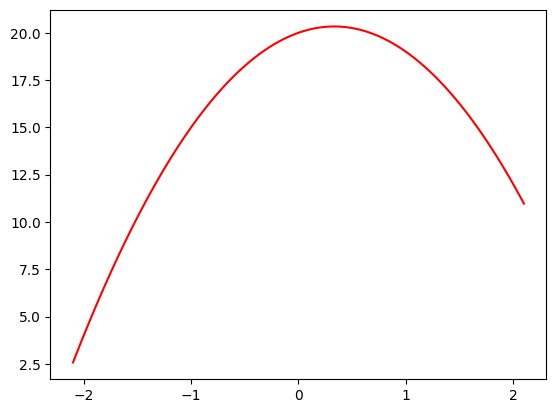

In [46]:
plot_function(f)

In [47]:
from numpy.random import normal,seed,uniform
np.random.seed(42)

In [48]:
def noise(x,scale): return normal(scale=scale,size=x.shape)
def add_noise(x,mult,add):return x*(1+noise(x,mult))+noise(x,add)

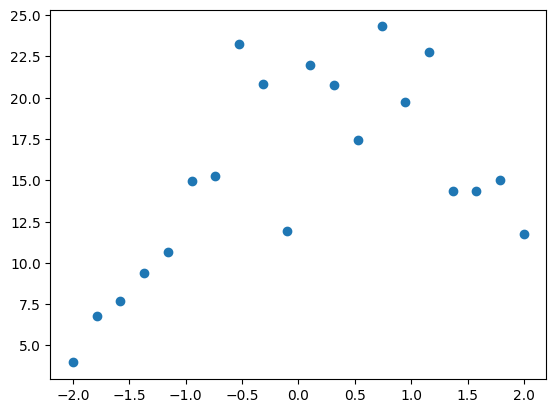

In [51]:
x=np.linspace(-2,2,num=20)[:,None]
y=add_noise(f(x),0.2,1.3)
plt.scatter(x,y);

Now, we try to underfit/overfit and observe the results.

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    model.fit(x,y)
    plt.scatter(x,y)
    plot_function(model.predict)

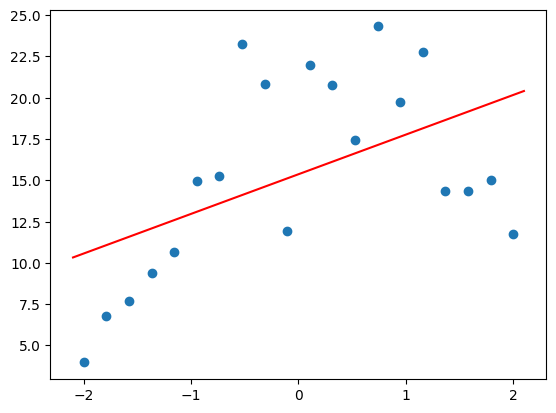

In [53]:
plot_poly(1) #fitting our points to a straight line- underfitting

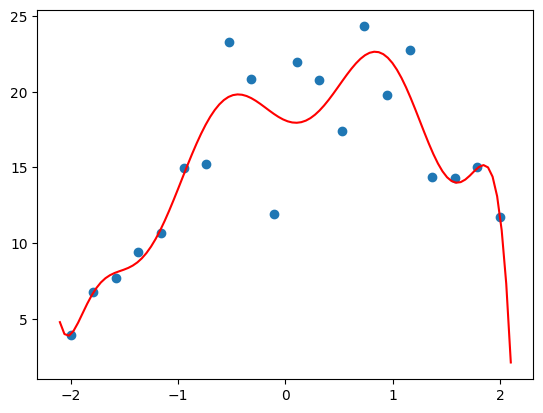

In [55]:
plot_poly(10) #overfitting

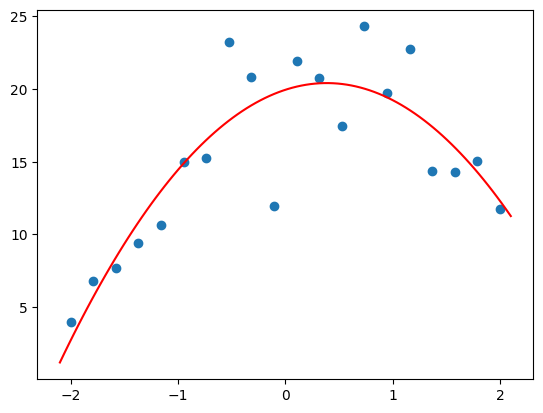

In [56]:
plot_poly(2)

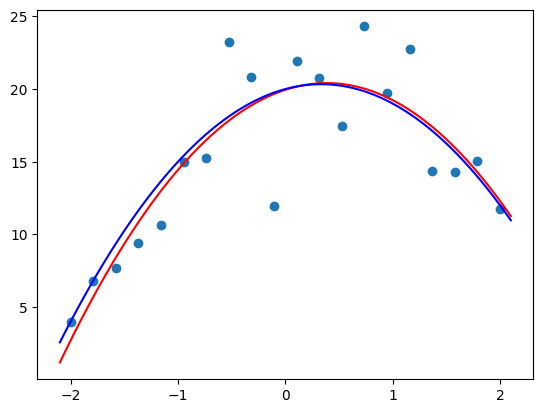

In [57]:
plot_poly(2)
plot_function(f,color='b')

clearly able to see they almost coincide and is just about right


In [58]:
dds=tok_ds.train_test_split(0.25,seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

#validation set here is called test and not validate


the test set is another dataset thats held out from training.Its held out from reporting metrics too. The accuracy of a model on the test set is only ever checked after you've completed your entire training process.

In [59]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [60]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


In [61]:
np.set_printoptions(precision=2, suppress=True)

np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

In [62]:
np.corrcoef(housing.MedInc,housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [63]:
def corr(x,y):return np.corrcoef(x,y)[0][1]
corr(housing.MedInc,housing.MedHouseVal)

0.6760250732906

In [64]:
def show_corr(df,a,b):
    x,y=df[a],df[b]
    plt.scatter(x,y,alpha=0.5,s=4)
    plt.title(f'{a} vs {b}; r:{corr(x,y):.2f}')

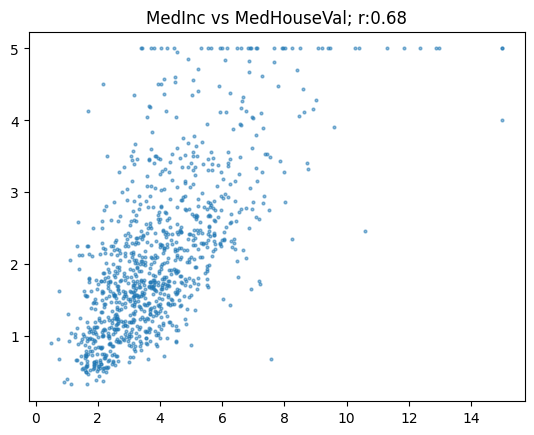

In [65]:
show_corr(housing,'MedInc','MedHouseVal')

corrcoeff=0.68 looks something like this. Somewhat reasonable a relationship with a decent variation as well.

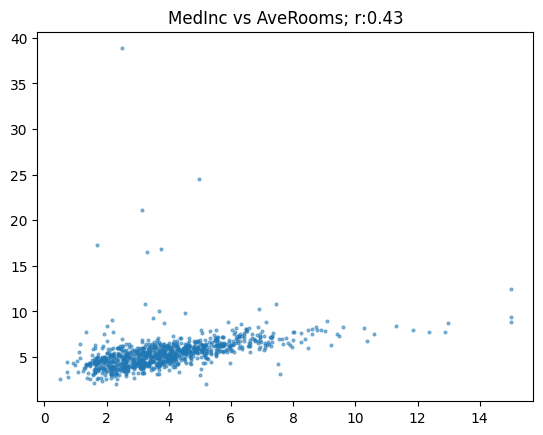

In [66]:
show_corr(housing,'MedInc','AveRooms')

to show that r is very sensitive to the outliers 

let's remove the outliers and try again

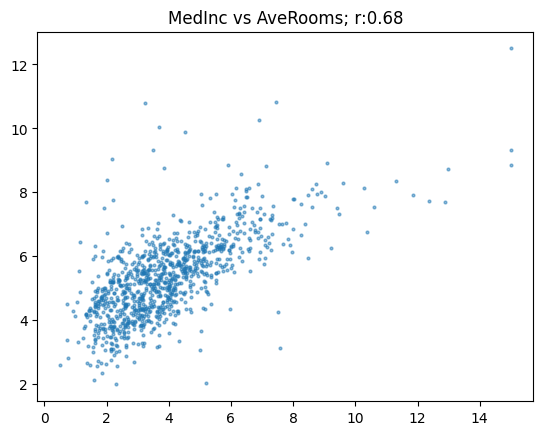

In [67]:
subset=housing[housing.AveRooms<15]
show_corr(subset,'MedInc','AveRooms')

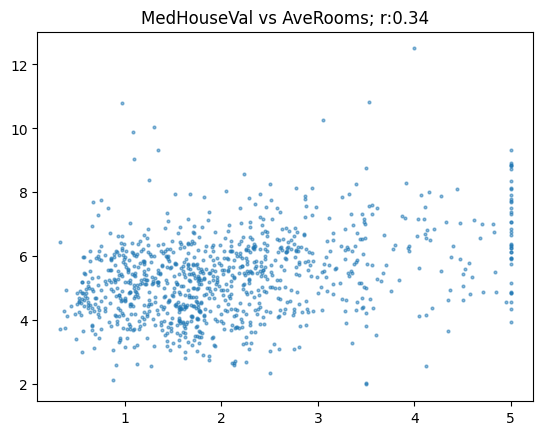

In [68]:
show_corr(subset,'MedHouseVal','AveRooms')

In [69]:
def corr_d(eval_pred):return {'pearson':corr(*eval_pred)}

Training our model. 

In [71]:
from transformers import TrainingArguments, Trainer

In [72]:
bs=128
epochs=4

In [73]:
lr=8e-5

In [74]:
args = TrainingArguments('outputs', 
                         learning_rate=lr, 
                         warmup_ratio=0.1, 
                         lr_scheduler_type='cosine', 
                         fp16=True,
                         evaluation_strategy="epoch", 
                         per_device_train_batch_size=bs, 
                         per_device_eval_batch_size=bs*2,
                         num_train_epochs=epochs,
                         weight_decay=0.01, 
                         report_to='none')

In [75]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
trainer.train();

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.027775,0.801650
2,No log,0.022096,0.822223
3,0.032500,0.022542,0.833855
4,0.032500,0.022226,0.833712


In [77]:
preds=trainer.predict(eval_ds).predictions.astype(float)
preds

array([[ 0.38],
       [ 0.73],
       [ 0.58],
       [ 0.35],
       [-0.05],
       [ 0.53],
       [ 0.49],
       [-0.02],
       [ 0.32],
       [ 1.11],
       [ 0.24],
       [ 0.27],
       [ 0.71],
       [ 0.95],
       [ 0.75],
       [ 0.46],
       [ 0.3 ],
       [-0.05],
       [ 0.59],
       [ 0.33],
       [ 0.47],
       [ 0.2 ],
       [ 0.12],
       [ 0.23],
       [ 0.55],
       [-0.03],
       [-0.05],
       [-0.04],
       [-0.02],
       [ 0.65],
       [ 0.35],
       [ 0.02],
       [ 0.68],
       [ 0.48],
       [ 0.43],
       [ 0.24]])

In [78]:
preds=np.clip(preds,0,1)

In [79]:
preds

array([[0.38],
       [0.73],
       [0.58],
       [0.35],
       [0.  ],
       [0.53],
       [0.49],
       [0.  ],
       [0.32],
       [1.  ],
       [0.24],
       [0.27],
       [0.71],
       [0.95],
       [0.75],
       [0.46],
       [0.3 ],
       [0.  ],
       [0.59],
       [0.33],
       [0.47],
       [0.2 ],
       [0.12],
       [0.23],
       [0.55],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.65],
       [0.35],
       [0.02],
       [0.68],
       [0.48],
       [0.43],
       [0.24]])

In [80]:
import datasets
submission=datasets.Dataset.from_dict({
    'id':eval_ds['id'],
    'score':preds
})
submission.to_csv('submission.csv',index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

855